In [1]:
import os
from keras.datasets import imdb
from keras.preprocessing import sequence, text
from keras.layers import Flatten, Dense, Embedding, LSTM
from keras.models import Sequential
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
max_features = 10000 #作为特征的单词个数
max_len = 100 #100个单词后截断文本
training_samples = 1000
validation_samples = 100

In [20]:
imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')
glove_dir = './glove.6B/'

In [21]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [22]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print ("Fond %s unique tokens." % len(word_index))

Fond 88582 unique tokens.


In [23]:
data = sequence.pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)

print ('Shape of data tensor', data.shape)
print ('Shape of labels tensor', labels.shape)

Shape of data tensor (25000, 100)
Shape of labels tensor (25000,)


In [24]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [25]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

In [26]:
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
    
f.close()

print ('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [27]:
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [35]:
model = Sequential()

model.add(Embedding(max_features,100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [37]:
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6950 - acc: 0.5440 - val_loss: 0.6536 - val_acc: 0.6000
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6526 - acc: 0.6230 - val_loss: 0.6634 - val_acc: 0.6200
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6240 - acc: 0.6460 - val_loss: 1.1758 - val_acc: 0.4700
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6085 - acc: 0.6840 - val_loss: 0.6033 - val_acc: 0.6500
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5756 - acc: 0.7000 - val_loss: 0.6407 - val_acc: 0.6100
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5519 - acc: 0.7150 - val_loss: 0.5563 - val_acc: 0.7000
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5215 - acc: 0.7360 - val_loss: 0.6906 - val_acc: 0.6200
Epoch 8/50
1000

In [38]:
# https://github.com/cleemesser/keras-layer-norm-work
from lstm_ln import LSTM_LN
model_ln = Sequential()

model_ln.add(Embedding(max_features,100))
model_ln.add(LSTM_LN(128))
model_ln.add(Dense(1, activation='sigmoid'))
model_ln.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_ln_3 (LSTM_LN)          (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_ln.layers[0].set_weights([embedding_matrix])
model_ln.layers[0].trainable = False

In [40]:
model_ln.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])
history_ln = model_ln.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6853 - acc: 0.5650 - val_loss: 0.6708 - val_acc: 0.6100
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6513 - acc: 0.6120 - val_loss: 0.7009 - val_acc: 0.5500
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6414 - acc: 0.6320 - val_loss: 0.6445 - val_acc: 0.6000
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6099 - acc: 0.6820 - val_loss: 0.6467 - val_acc: 0.6300
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5900 - acc: 0.6860 - val_loss: 0.6069 - val_acc: 0.6400
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5420 - acc: 0.7360 - val_loss: 0.6009 - val_acc: 0.6200
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5509 - acc: 0.7260 - val_loss: 0.6277 - val_acc: 0.6100
Epoch 8/50
1000

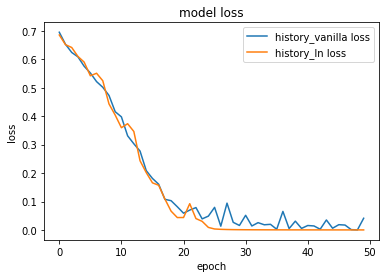

In [41]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history_ln.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['history_vanilla loss','history_ln loss'], loc='upper right')
plt.show()

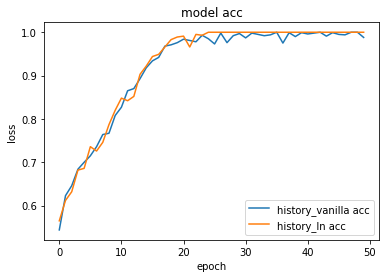

In [44]:
plt.plot(history.history['acc'])
plt.plot(history_ln.history['acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['history_vanilla acc','history_ln acc'], loc='lower right')
plt.show()